In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
import os

In [2]:
import numpy as np

In [3]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

/home/tom/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tom/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/tom/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/tom/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Обучение

In [13]:
# os.chdir('..')
from src.DeepGenerativeModels.AutoEncoders import FlowVAE
from src.DeepGenerativeModels.RealNVP import RealNVP

ModuleNotFoundError: No module named 'DeepGenerativeModels'

## VAE

In [7]:
model = FlowVAE(2, 28*28, device=device)

NameError: name 'RealNVP' is not defined

In [453]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [454]:
import utils

In [455]:
utils.trainer(model = model, 
        optimizer = optimizer, 
        dataset = train_data, 
        count_of_epoch = 2,
        batch_size = 64,              
        callback = None,
        progress = tqdm)

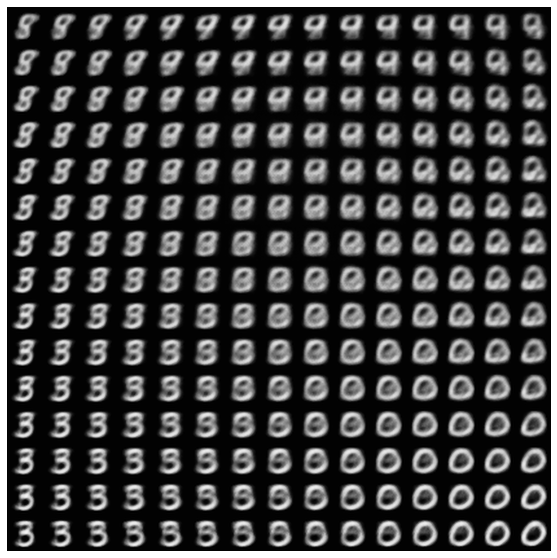

In [459]:
figure = utils.draw_samples_grid_vae(model)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')                             
plt.show()                                                                    

In [460]:
# figure = utils.draw_samples_grid_vae(model)

# plt.figure(figsize=(10, 10))
# plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
# plt.axis('off')
# plt.show()

## IWAE

In [461]:
# model = IWAE(2, 28*28, K = 2, device=device)

In [462]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [463]:
# utils.trainer(model = model, 
#                 optimizer = optimizer, 
#                 dataset = train_data, 
#                 count_of_epoch = 1,
#                 batch_size = 64,
#                 callback = None,
#                 progress = tqdm)

In [464]:
# figure = utils.draw_samples_grid_vae(model)

# plt.figure(figsize=(10, 10))
# plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
# plt.axis('off')
# plt.show()

# Draw posterior

In [465]:
batch_x, batch_y = list(DataLoader(train_data))[0]

In [466]:
x = np.linspace(-4, 4.0, 50)
y = np.linspace(-4, 4.0, 50)

xx, yy = np.meshgrid(x, y)

probas = np.zeros(xx.shape)
 
for i in tqdm(range(xx.shape[0])):
    for j in range(xx.shape[1]):
        z = torch.Tensor([xx[i,j], yy[i,j]]).view([1, -1])
        probas[i, j] = model.posterior_z(z, batch_x)

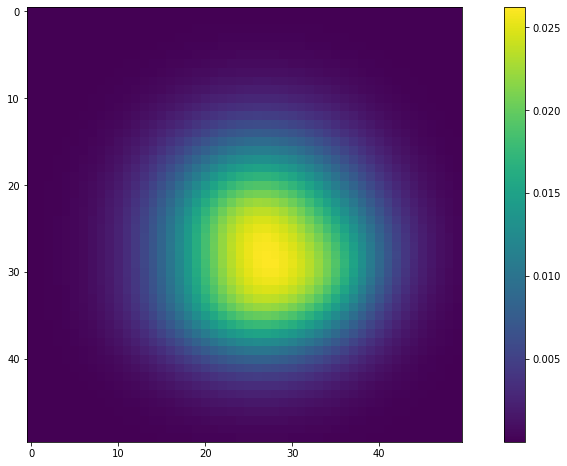

In [467]:
plt.rcParams['figure.figsize'] = (15, 8)

im = plt.imshow(np.exp(probas))
plt.colorbar(im)
plt.show()